<a href="https://colab.research.google.com/github/Abdulkadir2516/P115_sv6/blob/main/Plaka_tespiti_faster_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Drive bağlantısı Yapılacak
dataset zipten çıkarılacak
dataset yüklenmeli
gerekli kütüphaneler
coco fortmatı düzeltilmesi
veriya hazırlama
Faster RCCN modeli oluşturma
eğitimi başlatma
testler
"""

SyntaxError: invalid syntax (<ipython-input-1-ba9c0ef1efa6>, line 1)

In [4]:
!ls

drive  sample_data


In [5]:
%cd /content/drive/MyDrive/plaka_tespit/

/content/drive/MyDrive/plaka_tespit


In [ ]:
!ls

In [ ]:
!unzip dataset_coco.zip

In [ ]:
!pip install pycocotools
!pip install Image
!pip install torchvision


In [7]:
from pycocotools.coco import COCO
from PIL import Image
import os

In [ ]:
!ls

In [ ]:
coco = COCO("train/_annotations.coco.json")# annotatiosn stored here

In [ ]:
coco.getAnnIds()

In [ ]:
img_id = list(sorted(coco.imgs.keys()))[0]
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)
img_data = coco.loadImgs(img_id)[0]
img_path = img_data['file_name']
img = Image.open(os.path.join("train", img_path)).convert("RGB")

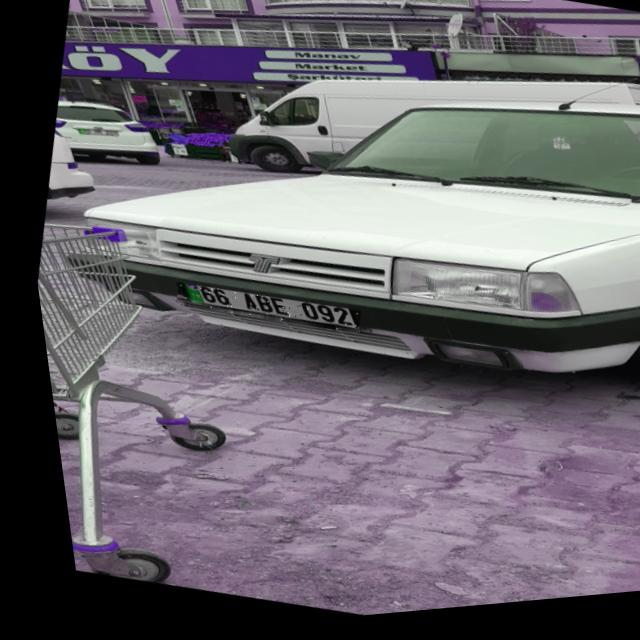

In [ ]:
img

In [ ]:
anns

[{'id': 0,
  'image_id': 0,
  'category_id': 1,
  'bbox': [165, 273, 188.832, 77.727],
  'area': 14677.267,
  'segmentation': [],
  'iscrowd': 0}]

In [9]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from pycocotools.coco import COCO


In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        img_data = coco.loadImgs(img_id)[0]
        img_path = img_data['file_name']
        img = Image.open(os.path.join(self.root, img_path)).convert("RGB")

        boxes = []
        labels = []
        for ann in anns:
            xmin = ann['bbox'][0]
            ymin = ann['bbox'][1]
            xmax = xmin + ann['bbox'][2]
            ymax = ymin + ann['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(ann['category_id'])

        if boxes:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
        else:
            # Provide dummy values or skip the image
            boxes = torch.zeros((0, 4), dtype=torch.float32)  # Empty tensor of correct shape
            labels = torch.zeros(0, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

def get_transform(train):
    transforms = []
    if train:
        transforms.append(torchvision.transforms.ToTensor())  # Convert PIL Image to tensor
        transforms.append(torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])) # Use torchvision.transforms.Normalize instead of F.normalize
    return torchvision.transforms.Compose(transforms)

In [ ]:
!ls


dataset_coco.zip		 README.dataset.txt   test   valid
Plaka_tespiti_faster_rcnn.ipynb  README.roboflow.txt  train


In [ ]:
dataset = CustomDataset(root="./train", annotation="train/_annotations.coco.json", transforms=get_transform(train=True))
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Load pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the head of the model
num_classes = 2  # +1 for background class
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()

    print(f"Epoch: {epoch}, Loss: {losses.item()}")

# Save the trained model
torch.save(model.state_dict(), "fasterrcnn_model22.pth")


loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


In [ ]:
!ls

dataset_coco.zip      Plaka_tespiti_faster_rcnn.ipynb  README.roboflow.txt  train
fasterrcnn_model.pth  README.dataset.txt	       test		    valid


In [ ]:
# Load the trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # +1 for background class
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
# Load the model state dictionary and map it to the CPU if no GPU is available
model.load_state_dict(torch.load("fasterrcnn_model.pth", map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

# Now you can use the loaded model for inference
# ...

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-8-d129da9dc9af>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
import torchvision
from torchvision import transforms as T
from PIL import Image
import os

import matplotlib.pyplot as plt
import cv2

# Load the trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # +1 for background class
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
# Load the model state dictionary and map it to the CPU if no GPU is available
model.load_state_dict(torch.load("fasterrcnn_model.pth", map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

# Test with images in the test folder
test_image_folder = "test2"  # Replace with your test image folder path
test_image_paths = [os.path.join(test_image_folder, filename) for filename in os.listdir(test_image_folder) if filename.endswith(('.jpg', '.png'))]

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# Create the output directory if it doesn't exist
output_dir = "test_output2"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for image_path in test_image_paths:
    img = Image.open(image_path).convert("RGB")
    img_tensor = get_transform(train=False)(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        prediction = model(img_tensor)[0]

    # Draw bounding boxes on the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()

    for i in range(len(boxes)):
        if scores[i] > 0.5:  # Adjust threshold as needed
            xmin, ymin, xmax, ymax = boxes[i]
            cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)

    # Save the image with bounding boxes
    output_path = os.path.join(output_dir, os.path.basename(image_path))
    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

<ipython-input-9-13ae51432f26>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fasterrcnn_model.pth", map_location=torch.device('cpu')))
